In [1]:
# Dependencies
import requests
import pandas as pd
from census import Census
import hvplot.pandas
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Import U.S. Census API Key
from config import api_key

# Create an instance of the Census library
c = Census(api_key)

In [3]:
# Variables 
#B08301_001E is the estimated total workers
#B08301_021E is the estimated workers who worked from home

variables = ['B08301_001E', 'B08301_021E']

# Years we are looking at
years = [2020, 2021, 2022]

# FIPS code to state names
names_state = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia',
    '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois',
    '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana',
    '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
    '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada',
    '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina',
    '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania',
    '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas',
    '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia',
    '55': 'Wisconsin', '56': 'Wyoming', '72': 'Puerto Rico'
}

# List to store the data for all years
all_states = []

In [4]:
# Loop through each year 
for year in years:
    # Get the data for all states for this year
    data = c.acs5.get(variables, geo={"for": "state:*"}, year=year)
    
    # Convert the list of lists to a DataFrame
    wfh_df = pd.DataFrame(data[1:], columns=data[0])
    
    # Add the year as a column to the DataFrame
    wfh_df['year'] = year
    
    # State FIPS codes to state names
    wfh_df['names_state'] = wfh_df['state'].map(names_state)
    
    # Append this year's data to the all_data list
    all_states.append(wfh_df)

# Create the DataFrame 
wfh_df = pd.concat(all_states, ignore_index=True)

# Display the columns: State Name, Year, Total Workers, Workers Who Work From Home
wfh_df = wfh_df[['names_state', 'year', 'B08301_001E', 'B08301_021E']]

# Rename the columns
wfh_df.columns = ['State', 'Year', 'Total Workers', 'Workers Who Work From Home']

# Convert the 'Total Workers' and 'Workers Who Work From Home' columns to numeric values because strings will prevent numeric operations
wfh_df['Total Workers'] = wfh_df['Total Workers'].astype(int)
wfh_df['Workers Who Work From Home'] = wfh_df['Workers Who Work From Home'].astype(int)

# Calculate the percentage of workers who work from home
wfh_df['Percentage of Workers Who Work From Home'] = (
    wfh_df['Workers Who Work From Home'] / wfh_df['Total Workers']
) * 100

# Format the percentage column to two decimal places
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].apply(lambda x: "{:.2f}%".format(x))

# Display the DataFrame
wfh_df

,State,Year,Total Workers,Workers Who Work From Home,Percentage of Workers Who Work From Home
0,California,2020,18239892,1529697,8.39%
1,West Virginia,2020,730395,33353,4.57%
2,Utah,2020,1517044,138218,9.11%
3,New York,2020,9219025,634197,6.88%
4,District of Columbia,2020,379090,46472,12.26%
...,...,...,...,...,...
148,Washington,2022,3722716,575184,15.45%
149,West Virginia,2022,723217,49655,6.87%
150,Wisconsin,2022,2974249,300409,10.10%
151,Wyoming,2022,284555,21902,7.70%


In [5]:
#Ensure the 'Percentage of Workers Who Work From Home' column is numeric
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].apply(
    lambda x: float(x.replace('%', '').replace(',', '')) if isinstance(x, str) else x
)

# Handle NaNs in the Percentage calculation
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].fillna(0)

#Group by 'State' and 'Year' and calculate the mean
mean_df = wfh_df.groupby(['State', 'Year'])['Percentage of Workers Who Work From Home'].mean().reset_index()

#Pivot the data
wfh_percentage_df = mean_df.pivot(index='State', columns='Year', values='Percentage of Workers Who Work From Home')

#Fill any NaN values with 0
wfh_percentage_df = wfh_percentage_df.fillna("0")

# Clean up the column name
wfh_percentage_df.columns = [f"Percentage of Workers Who Work From Home ({year})" for year in wfh_percentage_df.columns]

#Format the values back to percentage
wfh_percentage_df = wfh_percentage_df.map(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)

# Reset index to make 'State' a column
wfh_percentage_df.reset_index

# Display the Dataframe
wfh_percentage_df

,Percentage of Workers Who Work From Home (2020),Percentage of Workers Who Work From Home (2021),Percentage of Workers Who Work From Home (2022)
State,,,
Alabama,4.43%,0,0
Alaska,6.03%,7.09%,8.06%
Arizona,8.88%,11.71%,14.26%
Arkansas,4.37%,5.63%,6.75%
California,8.39%,11.36%,13.63%
Colorado,10.80%,13.99%,16.49%
Connecticut,7.64%,10.40%,12.61%
Delaware,7.15%,9.84%,11.64%
District of Columbia,12.26%,19.83%,25.03%


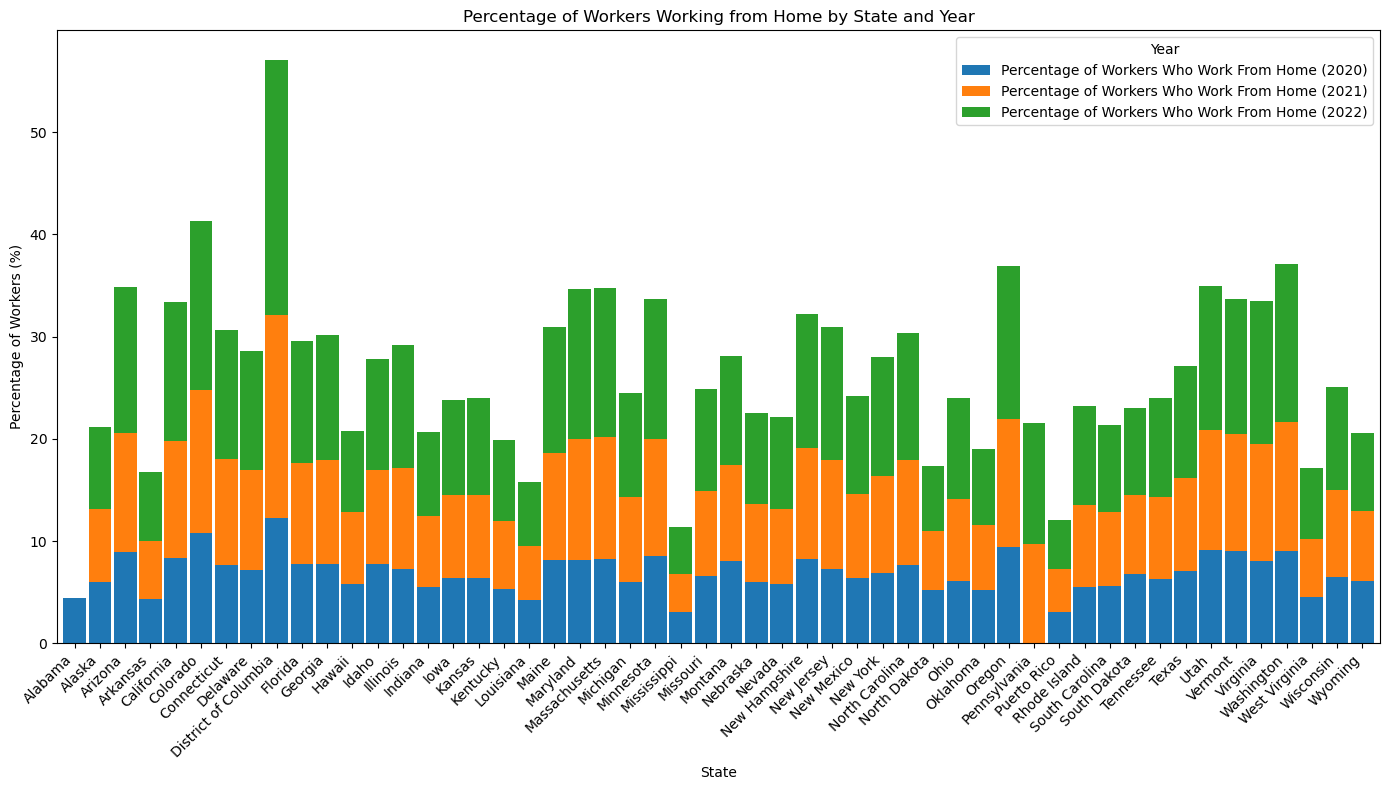

In [36]:
# Clean up columns by removing '%' and ',' then convert to float
wfh_percentage_df = wfh_percentage_df.replace({'%': '', ',': ''})

# Create the stacked bar chart
ax = wfh_percentage_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.9)

# Add title and labels
ax.set_title('Percentage of Workers Working from Home by State and Year')
ax.set_xlabel('State')
ax.set_ylabel('Percentage of Workers (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend to the plot
ax.legend(title="Year", loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

In [37]:
plt.savefig("./Images/workfromhomestateandyears.png")

<Figure size 640x480 with 0 Axes>

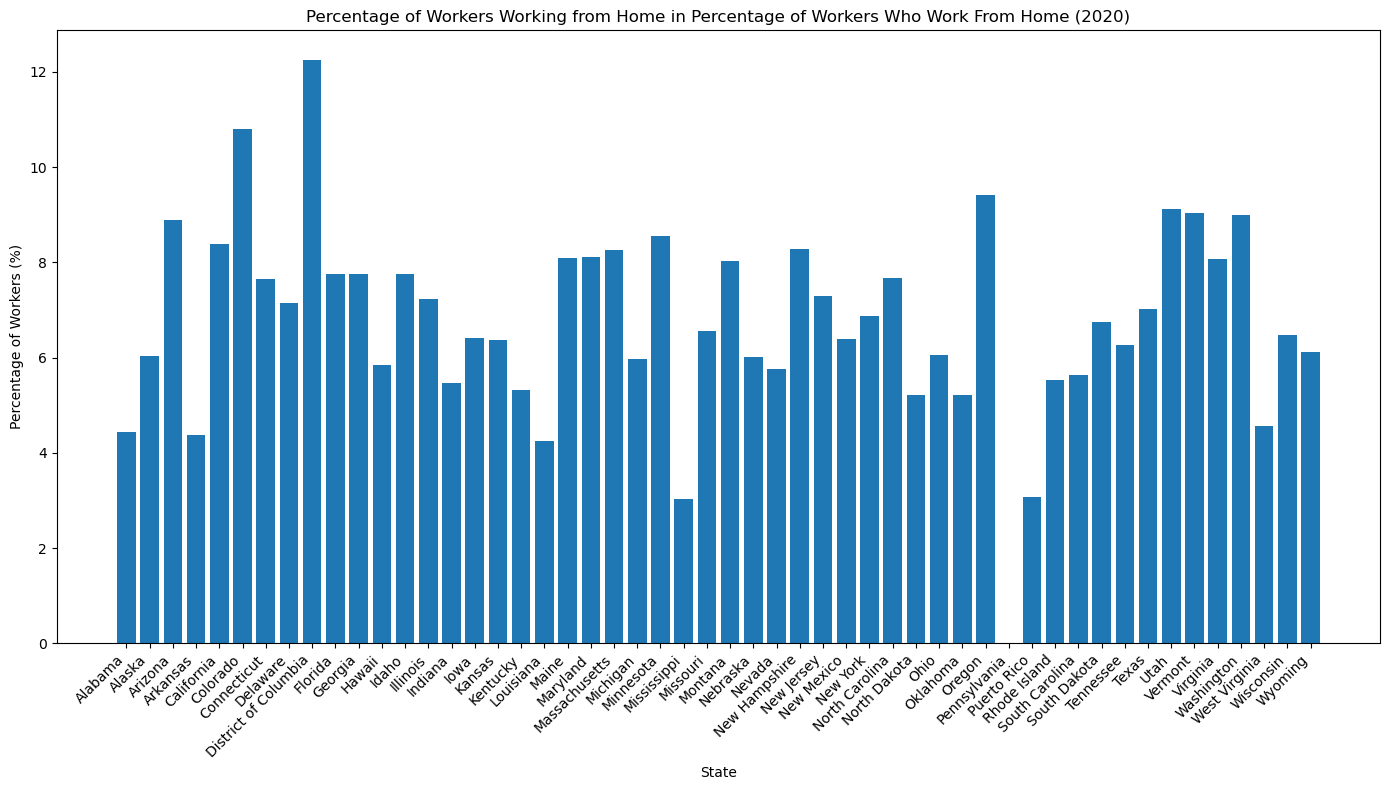

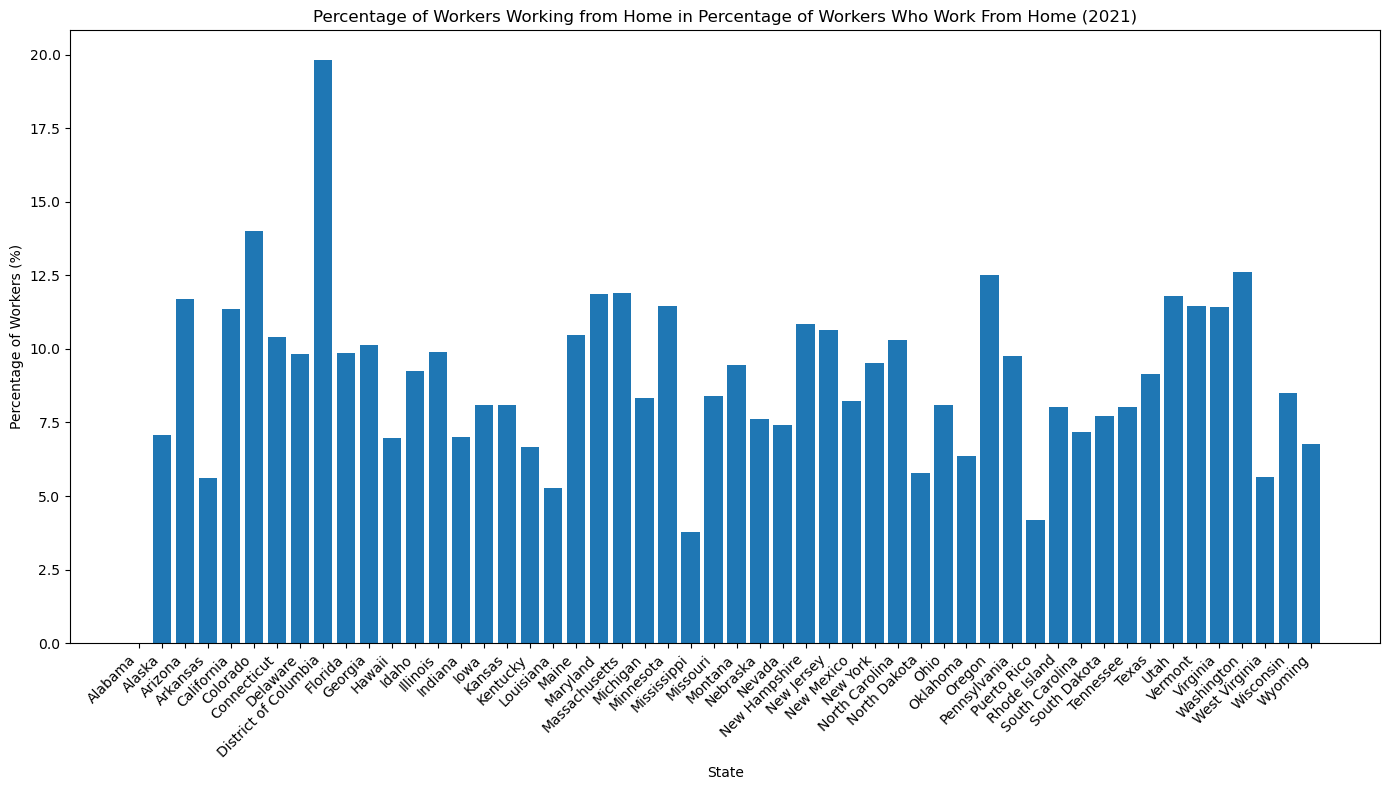

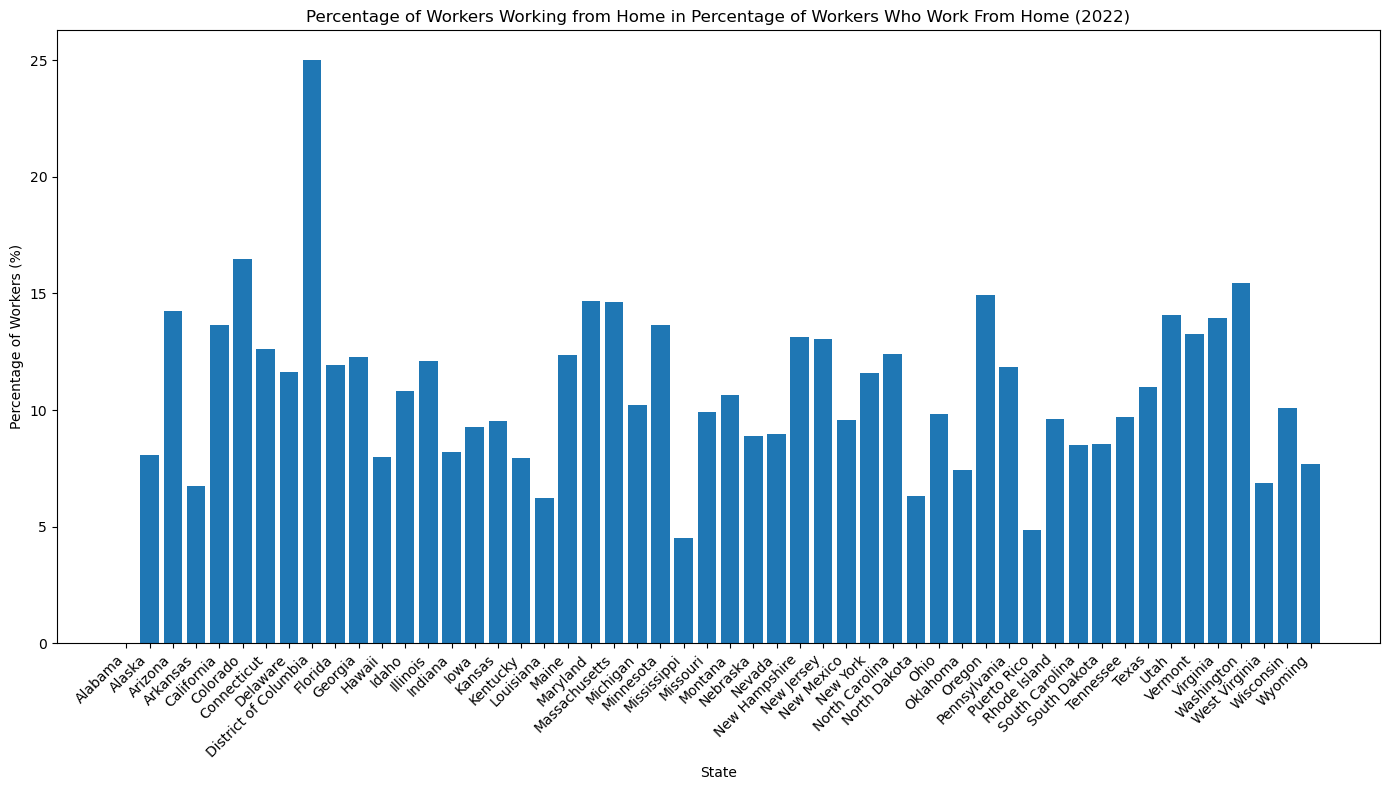

In [38]:
# Define the years
years = ['Percentage of Workers Who Work From Home (2020)', 
         'Percentage of Workers Who Work From Home (2021)', 
         'Percentage of Workers Who Work From Home (2022)']

# Retrieve the state names from the index
states = wfh_percentage_df.index

# Create a separate bar chart for each year
for year in years:
    # Extract the data for the current year
    year_data = wfh_percentage_df[year]
    
    # Create an array of positions for each bar (x-values for the bars)
    indices = np.arange(len(year_data)) 
    
    # Create the bar chart for the current year
    plt.figure(figsize=(14, 8)) 
    plt.bar(indices, year_data)

    # Add title and labels for each year
    plt.title(f'Percentage of Workers Working from Home in {year}')
    plt.xlabel('State')
    plt.ylabel('Percentage of Workers (%)')

    # Set the x-ticks to match the state names (assuming 'state' is in the index)
    plt.xticks(indices, states, rotation=45, ha='right')
  
    # Display the plot
    plt.tight_layout()
    plt.show()

In [39]:
plt.savefig("./Images/workfromhomestateseparatecharts.png")

<Figure size 640x480 with 0 Axes>

In [10]:
# Variables for male and female workers
gender_total = {
    'Male': {
        'total_workers': 'B08406_018E',
        'wfh_workers': 'B08406_034E'
    },
    'Female': {
        'total_workers': 'B08406_035E',
        'wfh_workers': 'B08406_051E'
    }
}

# Years we are looking at
years = [2020, 2021, 2022]

# List to store data for all years
all_data_gender = []

In [11]:
# Loop through each year to get data for males and females
for year in years:
    for gender in gender_total:
        # Get the codes for the total workers and worked from home workers
        total_workers_code = gender_total[gender]['total_workers']
        wfh_workers_code = gender_total[gender]['wfh_workers']
        
        # Get the data for all states for this year and gender
        data = c.acs5.get([total_workers_code, wfh_workers_code], geo={"for": "state:*"}, year=year)
        
        # Process the data into a structured format
        for row in data:
            state_code = row['state']
            state_name = names_state.get(state_code, 'Unknown')
            total_workers = row.get(total_workers_code, None)
            wfh_workers = row.get(wfh_workers_code, None)
            
            # Calculate the percentage of workers working from home
            if total_workers and total_workers > 0:
                percentage_wfh = (wfh_workers / total_workers) * 100 if wfh_workers else 0
            else:
                percentage_wfh = 0
            
            # Only append the data we want
            gender_data = {
                'State': state_name,
                'Year': year,
                'Gender': gender,
                'Percentage Worked From Home': percentage_wfh
            }
            
            # Append the data for this state and gender to the all_data_gender list
            all_data_gender.append(gender_data)

# Convert to a DataFrame
gender_df = pd.DataFrame(all_data_gender)


In [12]:
# Convert values to numeric where necessary
gender_df['Percentage Worked From Home'] = pd.to_numeric(gender_df['Percentage Worked From Home'], errors='coerce')

# Pivot the data so that each year/gender has its own column
gender_percentage_df = gender_df.pivot_table(
    index='State', 
    columns=['Year', 'Gender'], 
    values='Percentage Worked From Home', 
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
gender_percentage_df.columns = [f"{year} {gender} Percentage Worked From Home" for year, gender in gender_percentage_df.columns]

# Format the percentage columns to show 2 decimal places and add the '%' symbol
gender_percentage_df = gender_percentage_df.map(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)

# Display the DataFrame
gender_percentage_df

,2020 Female Percentage Worked From Home,2020 Male Percentage Worked From Home,2021 Female Percentage Worked From Home,2021 Male Percentage Worked From Home,2022 Female Percentage Worked From Home,2022 Male Percentage Worked From Home
State,,,,,,
Alabama,4.88%,4.20%,6.18%,5.32%,7.45%,6.17%
Alaska,7.46%,4.67%,9.07%,5.27%,10.16%,6.15%
Arizona,10.13%,7.94%,13.22%,10.60%,16.10%,12.92%
Arkansas,4.78%,4.01%,6.11%,5.19%,7.40%,6.17%
California,9.31%,7.61%,12.53%,10.37%,15.02%,12.47%
Colorado,12.00%,9.83%,15.38%,12.89%,18.03%,15.25%
Connecticut,8.15%,7.51%,11.22%,10.15%,13.68%,12.31%
Delaware,7.15%,7.18%,10.12%,9.61%,12.25%,11.14%
District of Columbia,6.35%,5.09%,10.72%,8.37%,13.92%,11.08%


In [13]:
# Earnings categories
earnings_codes = {
    'Total workers: 1 to 9,999': 'B08519_002E',
    'Total workers: 10,000 to 14,999': 'B08519_003E',
    'Total workers: 15,000 to 24,999': 'B08519_004E',
    'Total workers: 25,000 to 34,999': 'B08519_005E',
    'Total workers: 35,000 to 49,999': 'B08519_006E',
    'Total workers: 50,000 to 64,999': 'B08519_007E',
    'Total workers: 65,000 to 74,999': 'B08519_008E',
    'Total workers: 75,000 or more': 'B08519_009E',
    'Worked from home: 1 to 9,999': 'B08519_056E',
    'Worked from home: 10,000 to 14,999': 'B08519_057E',
    'Worked from home: 15,000 to 24,999': 'B08519_058E',
    'Worked from home: 25,000 to 34,999': 'B08519_059E',
    'Worked from home: 35,000 to 49,999': 'B08519_060E',
    'Worked from home: 50,000 to 64,999': 'B08519_061E',
    'Worked from home: 65,000 to 74,999': 'B08519_062E',
    'Worked from home: 75,000 or more': 'B08519_063E',
}

# Years we are looking at
years = [2020, 2021, 2022]

# List to store the data for all years
all_data_earnings = []

In [14]:
# Loop through each year to get data for each earnings category
for year in years:
    # Request data for all earnings categories in each year
    data = c.acs5.get(list(earnings_codes.values()), geo={"for": "state:*"}, year=year)

    # Process the data into a structured format
    for row in data:
        state_code = row['state']
        state_name = names_state.get(state_code, 'Unknown')

        # Extract the earnings categories for this row
        earnings_data = {
            'State': state_name,
            'Year': year,
            'State Code': state_code,
        }

        # Loop through each earnings category and get the value
        for category, code in earnings_codes.items():
            earnings_data[category] = row.get(code, None)

        # Append this row's data
        all_data_earnings.append(earnings_data)

# Create a DataFrame
earnings_df = pd.DataFrame(all_data_earnings)

# Convert values to numeric
earnings_columns = list(earnings_codes.keys())
for col in earnings_columns:
    earnings_df[col] = pd.to_numeric(earnings_df[col], errors='coerce')

# Pivot the data so each year/earnings category combination is a separate column
earnings_years_df = earnings_df.pivot_table(
    index='State', 
    columns=['Year'], 
    values=earnings_columns, 
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
earnings_years_df.columns = [f"{year} {category}" for year, category in earnings_years_df.columns]

# Display the DataFrame
earnings_years_df

,"Total workers: 1 to 9,999 2020","Total workers: 1 to 9,999 2021","Total workers: 1 to 9,999 2022","Total workers: 10,000 to 14,999 2020","Total workers: 10,000 to 14,999 2021","Total workers: 10,000 to 14,999 2022","Total workers: 15,000 to 24,999 2020","Total workers: 15,000 to 24,999 2021","Total workers: 15,000 to 24,999 2022","Total workers: 25,000 to 34,999 2020",...,"Worked from home: 35,000 to 49,999 2022","Worked from home: 50,000 to 64,999 2020","Worked from home: 50,000 to 64,999 2021","Worked from home: 50,000 to 64,999 2022","Worked from home: 65,000 to 74,999 2020","Worked from home: 65,000 to 74,999 2021","Worked from home: 65,000 to 74,999 2022","Worked from home: 75,000 or more 2020","Worked from home: 75,000 or more 2021","Worked from home: 75,000 or more 2022"
State,,,,,,,,,,,,,,,,,,,,,
Alabama,249391.0,244426.0,237119.0,142970.0,137694.0,129464.0,318578.0,304130.0,276811.0,308303.0,...,17792.0,10350.0,13520.0,14972.0,5284.0,7334.0,9223.0,27470.0,39698.0,53610.0
Alaska,34652.0,34213.0,31511.0,18723.0,17376.0,17481.0,41284.0,36462.0,32186.0,43810.0,...,3555.0,2187.0,2736.0,3166.0,1281.0,1782.0,2132.0,5104.0,6932.0,9917.0
Arizona,345052.0,324305.0,303416.0,203834.0,186037.0,169889.0,453833.0,392734.0,343917.0,469907.0,...,67875.0,32531.0,46595.0,58289.0,16136.0,21756.0,31308.0,88957.0,130596.0,180573.0
Arkansas,143102.0,139203.0,130832.0,90212.0,85664.0,79904.0,214408.0,194694.0,170644.0,217835.0,...,11826.0,5978.0,8729.0,10800.0,3426.0,4981.0,5863.0,14779.0,21796.0,29178.0
California,1877066.0,1778502.0,1661978.0,1164511.0,1071405.0,983010.0,2406295.0,2148837.0,1909757.0,2376836.0,...,232890.0,152241.0,208185.0,221462.0,76597.0,111184.0,142720.0,591902.0,932822.0,1251875.0
Colorado,309129.0,294708.0,276884.0,165089.0,154814.0,141088.0,330494.0,291506.0,265523.0,380294.0,...,51417.0,36141.0,50687.0,56009.0,18963.0,27396.0,33888.0,122794.0,178369.0,239454.0
Connecticut,186008.0,183125.0,171009.0,92770.0,89306.0,84630.0,182344.0,171225.0,158704.0,191743.0,...,18130.0,14152.0,18780.0,20973.0,7165.0,10893.0,13480.0,60631.0,92610.0,122000.0
Delaware,50278.0,50025.0,47715.0,24589.0,24591.0,23234.0,50127.0,46982.0,43867.0,60718.0,...,5329.0,4416.0,6060.0,6672.0,1837.0,2717.0,3935.0,12314.0,18991.0,24880.0
District of Columbia,44756.0,41616.0,35262.0,20577.0,19154.0,17052.0,47719.0,39460.0,33751.0,60084.0,...,5432.0,5279.0,7721.0,7551.0,3376.0,4817.0,6014.0,24203.0,43676.0,60793.0


In [15]:
# Earnings categories
earnings_codes = {
    '1 to 9,999': 'B08519_002E',
    '10,000 to 14,999': 'B08519_003E',
    '15,000 to 24,999': 'B08519_004E',
    '25,000 to 34,999': 'B08519_005E',
    '35,000 to 49,999': 'B08519_006E',
    '50,000 to 64,999': 'B08519_007E',
    '65,000 to 74,999': 'B08519_008E',
    '75,000 or more': 'B08519_009E',
    'Worked from home: 1 to 9,999': 'B08519_056E',
    'Worked from home: 10,000 to 14,999': 'B08519_057E',
    'Worked from home: 15,000 to 24,999': 'B08519_058E',
    'Worked from home: 25,000 to 34,999': 'B08519_059E',
    'Worked from home: 35,000 to 49,999': 'B08519_060E',
    'Worked from home: 50,000 to 64,999': 'B08519_061E',
    'Worked from home: 65,000 to 74,999': 'B08519_062E',
    'Worked from home: 75,000 or more': 'B08519_063E',
}

# Request data for earnings categories for 2020
data_2020 = c.acs5.get(list(earnings_codes.values()), geo={"for": "state:*"}, year=2020)

# Process the data into a structured format
all_data_earnings_2020 = []
for row in data_2020:
    state_code = row['state']
    state_name = names_state.get(state_code, 'Unknown') 

    # Extract the earnings categories for this row
    earnings_data = {
        'State': state_name,
        'Year': 2020,
        'State Code': state_code,
    }

    # Loop through each earnings category and get the value
    for category, code in earnings_codes.items():
        earnings_data[category] = row.get(code, None)

    # Append this row's data
    all_data_earnings_2020.append(earnings_data)

# Create a DataFrame
earnings_df_2020 = pd.DataFrame(all_data_earnings_2020)

# Convert values to numeric where necessary
earnings_columns = list(earnings_codes.keys())
for col in earnings_columns:
    earnings_df_2020[col] = pd.to_numeric(earnings_df_2020[col], errors='coerce')

# Create the percentage columns
percentage_columns_2020 = []
for total_category in earnings_codes.keys():
    wfh_category = f"Worked from home: {total_category}"

    if wfh_category in earnings_df_2020.columns:
        earnings_df_2020[f'Percentage {total_category}'] = (
            (earnings_df_2020[wfh_category] / earnings_df_2020[total_category]) * 100
        )
        percentage_columns_2020.append(f'Percentage {total_category}')

# Create a new DataFrame with the percentage columns
percentage_df_2020 = earnings_df_2020[['State', 'Year'] + percentage_columns_2020]

# Pivot the data so that each year/earnings category combination is a separate column
final_percentage_2020_df = percentage_df_2020.pivot_table(
    index='State',
    columns=['Year'],
    values=percentage_columns_2020,
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
final_percentage_2020_df.columns = [f"{year} {category}" for year, category in final_percentage_2020_df.columns]

# Format the percentage columns to show 2 decimal places and add the '%' symbol
final_percentage_2020_df = final_percentage_2020_df.map(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)

# Display the DataFrame
final_percentage_2020_df

,"Percentage 1 to 9,999 2020","Percentage 10,000 to 14,999 2020","Percentage 15,000 to 24,999 2020","Percentage 25,000 to 34,999 2020","Percentage 35,000 to 49,999 2020","Percentage 50,000 to 64,999 2020","Percentage 65,000 to 74,999 2020","Percentage 75,000 or more 2020"
State,,,,,,,,
Alabama,5.12%,3.97%,3.30%,2.93%,3.52%,4.02%,5.43%,7.97%
Alaska,9.22%,7.93%,5.74%,5.28%,5.95%,4.61%,5.11%,5.42%
Arizona,8.53%,7.64%,6.58%,5.59%,7.84%,8.68%,10.19%,15.08%
Arkansas,5.07%,4.09%,3.23%,3.18%,3.27%,3.86%,5.53%,8.25%
California,9.25%,7.66%,6.25%,5.59%,6.37%,7.63%,8.24%,11.96%
Colorado,10.11%,8.71%,7.77%,7.14%,8.02%,9.60%,11.10%,17.57%
Connecticut,7.89%,6.62%,5.45%,5.18%,5.29%,6.35%,6.39%,12.07%
Delaware,6.29%,6.96%,5.80%,4.90%,4.30%,7.35%,6.77%,11.37%
District of Columbia,8.32%,6.43%,5.22%,3.52%,4.52%,5.72%,6.15%,5.94%


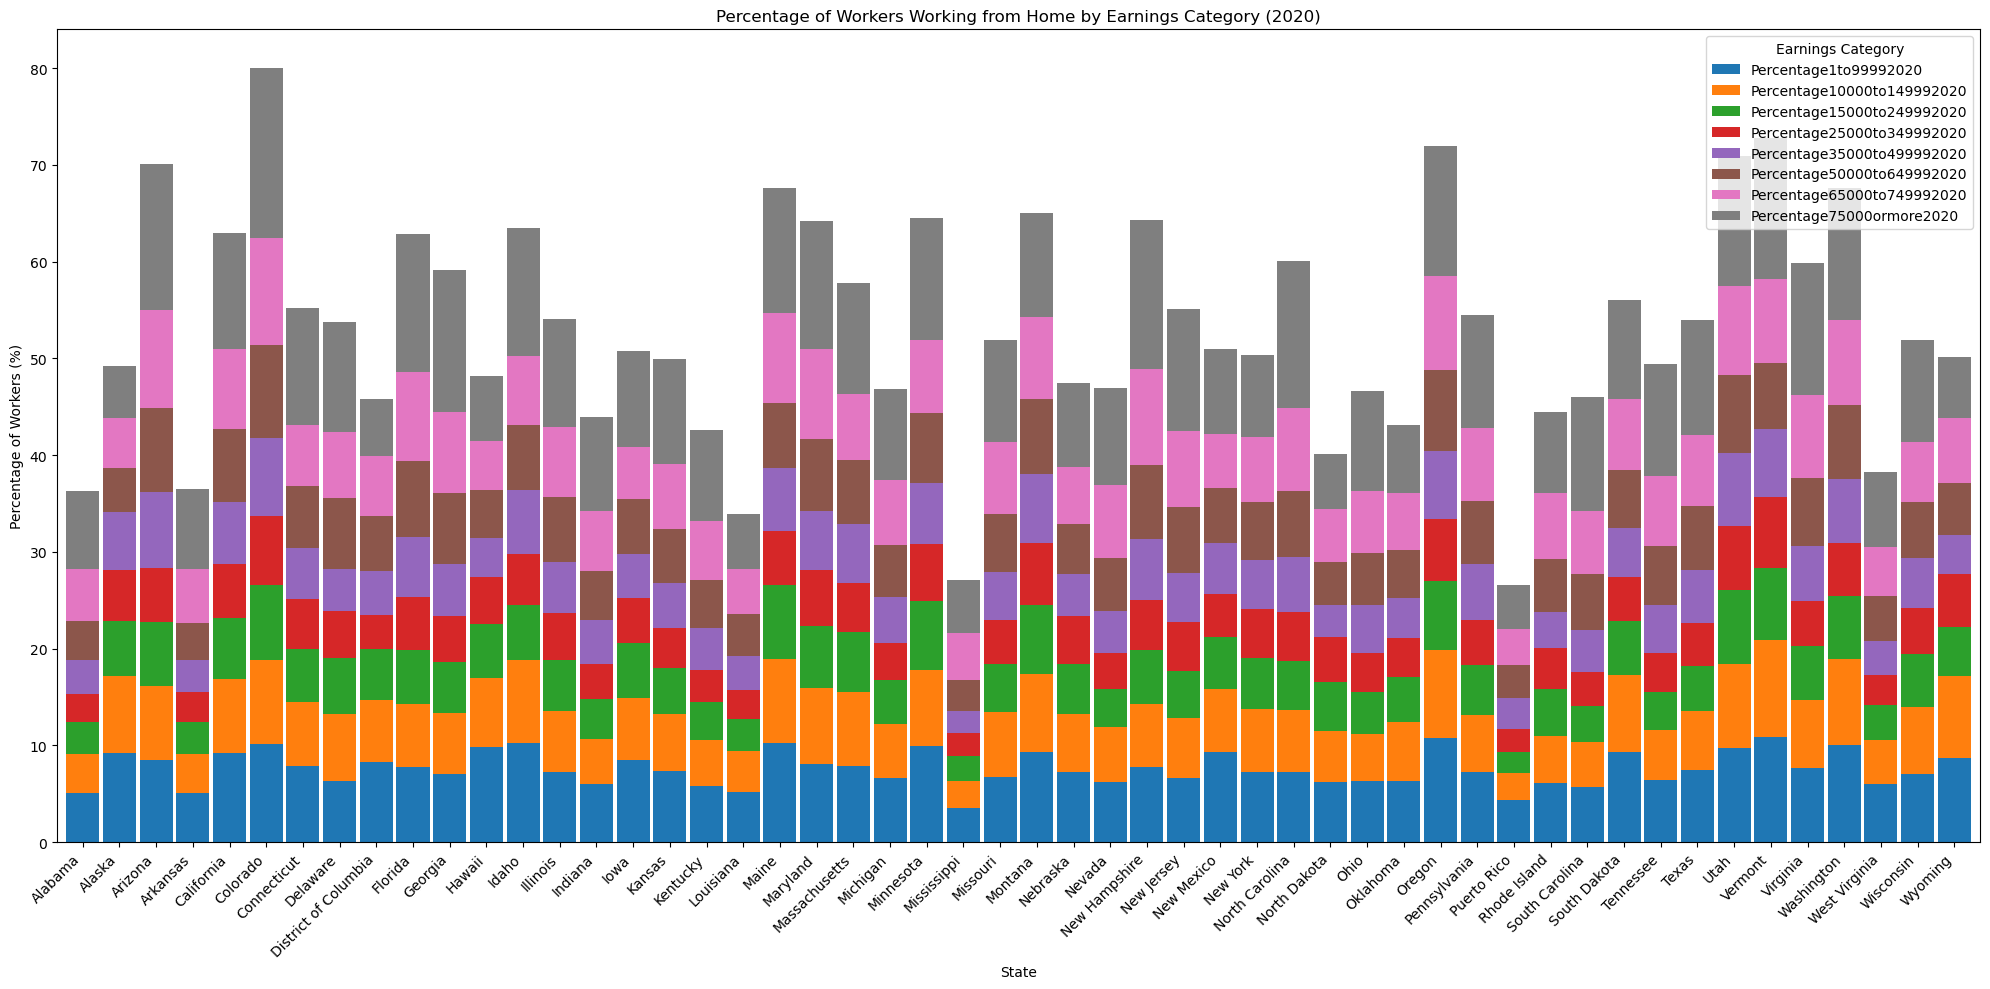

In [40]:
# Remove commas, spaces, and any special characters in column names
final_percentage_2020_df.columns = final_percentage_2020_df.columns.str.replace(r'[^A-Za-z0-9]', '')

# Define the categories (percentage columns)
categories = [
    'Percentage1to99992020',
    'Percentage10000to149992020',
    'Percentage15000to249992020',
    'Percentage25000to349992020',
    'Percentage35000to499992020',
    'Percentage50000to649992020',
    'Percentage65000to749992020',
    'Percentage75000ormore2020'
]

# Clean percentage values: remove '%' and ',' and convert to float in one step
final_percentage_2020_df[categories] = final_percentage_2020_df[categories].replace({'%': '', ',': ''}).astype(float)

# Create a stacked bar chart
final_percentage_2020_df[categories].plot(kind='bar', stacked=True, figsize=(20, 10), width=0.9)

# Add title and labels
plt.title('Percentage of Workers Working from Home by Earnings Category (2020)')
plt.xlabel('State')
plt.ylabel('Percentage of Workers (%)')
plt.xticks(rotation=45, ha='right')  # Rotate state names to avoid overlap
plt.legend(title="Earnings Category", loc='upper right')  # Move legend outside the plot

# Display the plot
plt.tight_layout()
plt.show()

In [41]:
plt.savefig("./Images/earnings2020.png")

<Figure size 640x480 with 0 Axes>

In [25]:
# Request data for earnings categories for 2021
data_2021 = c.acs5.get(list(earnings_codes.values()), geo={"for": "state:*"}, year=2021)

# Process the data into a structured format
all_data_earnings_2021 = []
for row in data_2021:
    state_code = row['state']
    state_name = names_state.get(state_code, 'Unknown') 

    # Extract the earnings categories for this row
    earnings_data = {
        'State': state_name,
        'Year': 2021,
        'State Code': state_code,
    }

    # Loop through each earnings category and get the value
    for category, code in earnings_codes.items():
        earnings_data[category] = row.get(code, None)

    # Append this row's data
    all_data_earnings_2021.append(earnings_data)

# Create a DataFrame
earnings_df_2021 = pd.DataFrame(all_data_earnings_2021)

# Convert values to numeric where necessary
earnings_columns = list(earnings_codes.keys())
for col in earnings_columns:
    earnings_df_2021[col] = pd.to_numeric(earnings_df_2021[col], errors='coerce')

# Create the percentage columns
percentage_columns_2021 = []
for total_category in earnings_codes.keys():
    wfh_category = f"Worked from home: {total_category}"

    if wfh_category in earnings_df_2021.columns:
        earnings_df_2021[f'Percentage {total_category}'] = (
            (earnings_df_2021[wfh_category] / earnings_df_2021[total_category]) * 100
        )
        percentage_columns_2021.append(f'Percentage {total_category}')

# Create a new DataFrame with the percentage columns
percentage_df_2021 = earnings_df_2021[['State', 'Year'] + percentage_columns_2021]

# Pivot the data so that each year/earnings category combination is a separate column
final_percentage_2021_df = percentage_df_2021.pivot_table(
    index='State',
    columns=['Year'],
    values=percentage_columns_2021,
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
final_percentage_2021_df.columns = [f"{year} {category}" for year, category in final_percentage_2021_df.columns]

# Format the percentage columns to show 2 decimal places and add the '%' symbol
final_percentage_2021_df = final_percentage_2021_df.map(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)

# Display the DataFrame
final_percentage_2021_df

,"Percentage 1 to 9,999 2021","Percentage 10,000 to 14,999 2021","Percentage 15,000 to 24,999 2021","Percentage 25,000 to 34,999 2021","Percentage 35,000 to 49,999 2021","Percentage 50,000 to 64,999 2021","Percentage 65,000 to 74,999 2021","Percentage 75,000 or more 2021"
State,,,,,,,,
Alabama,5.89%,4.64%,3.99%,3.99%,4.29%,5.04%,6.64%,10.28%
Alaska,9.44%,7.87%,7.26%,6.01%,6.69%,5.85%,6.90%,6.83%
Arizona,10.21%,9.34%,7.88%,7.28%,10.35%,11.86%,12.86%,19.68%
Arkansas,5.57%,4.80%,3.85%,3.75%,4.31%,5.47%,7.32%,10.79%
California,10.81%,9.11%,7.57%,6.95%,8.16%,10.40%,11.30%,17.28%
Colorado,11.65%,10.54%,9.23%,9.05%,9.97%,12.99%,14.57%,22.32%
Connecticut,9.35%,8.32%,6.51%,6.34%,6.86%,8.74%,9.51%,16.92%
Delaware,7.71%,7.96%,7.19%,6.49%,6.43%,9.91%,9.17%,16.00%
District of Columbia,10.58%,8.74%,6.92%,5.94%,6.93%,9.11%,9.18%,10.75%


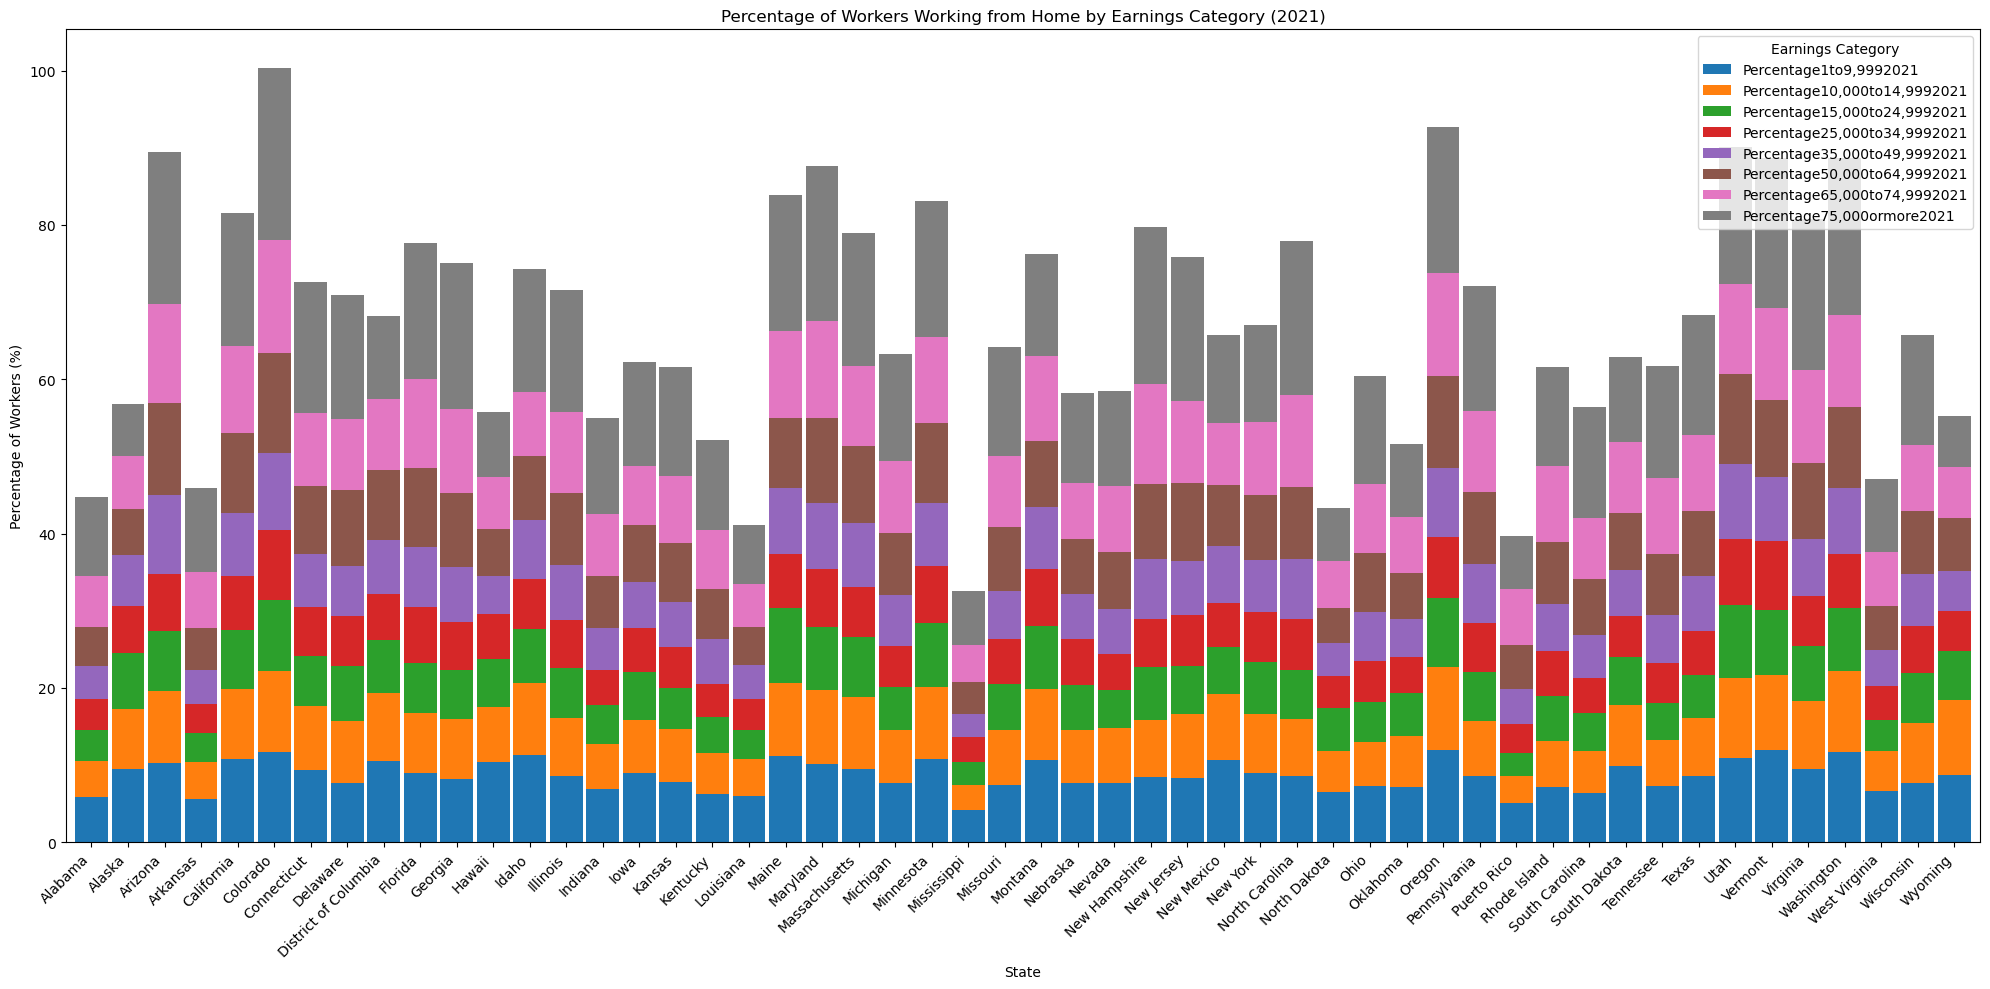

In [42]:
# Clean up column names by removing spaces (keeping commas and other symbols)
final_percentage_2021_df.columns = final_percentage_2021_df.columns.str.replace(' ', '')

# Define the categories (percentage columns)
categories_2021 = [
    'Percentage1to9,9992021',
    'Percentage10,000to14,9992021',
    'Percentage15,000to24,9992021',
    'Percentage25,000to34,9992021',
    'Percentage35,000to49,9992021',
    'Percentage50,000to64,9992021',
    'Percentage65,000to74,9992021',
    'Percentage75,000ormore2021'
]

# Clean the percentage values: remove '%' and ',' and convert to float
final_percentage_2021_df[categories_2021] = final_percentage_2021_df[categories_2021].replace({'%': '', ',': ''}).astype(float)

# Create a stacked bar chart
final_percentage_2021_df[categories_2021].plot(kind='bar', stacked=True, figsize=(20, 10), width=0.9)

# Adding title and labels
plt.title('Percentage of Workers Working from Home by Earnings Category (2021)')
plt.xlabel('State')
plt.ylabel('Percentage of Workers (%)')
plt.xticks(rotation=45, ha='right')  # Rotate state names to avoid overlap
plt.legend(title="Earnings Category", loc='upper right')  # Move legend outside the plot

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [43]:
plt.savefig("./Images/earnings2021.png")

<Figure size 640x480 with 0 Axes>

In [28]:
# Request data for earnings categories for 2022
data_2022 = c.acs5.get(list(earnings_codes.values()), geo={"for": "state:*"}, year=2022)

# Process the data into a structured format
all_data_earnings_2022 = []
for row in data_2022:
    state_code = row['state']
    state_name = names_state.get(state_code, 'Unknown')  

    # Extract the earnings categories for this row
    earnings_data = {
        'State': state_name,
        'Year': 2022,
        'State Code': state_code,
    }

    # Loop through each earnings category and get the value
    for category, code in earnings_codes.items():
        earnings_data[category] = row.get(code, None)

    # Append this row's data
    all_data_earnings_2022.append(earnings_data)

# Create a DataFrame
earnings_df_2022 = pd.DataFrame(all_data_earnings_2022)

# Convert values to numeric where necessary
earnings_columns = list(earnings_codes.keys())
for col in earnings_columns:
    earnings_df_2022[col] = pd.to_numeric(earnings_df_2022[col], errors='coerce')

# Create the percentage columns
percentage_columns_2022 = []
for total_category in earnings_codes.keys():
    wfh_category = f"Worked from home: {total_category}"

    if wfh_category in earnings_df_2022.columns:
        earnings_df_2022[f'Percentage {total_category}'] = (
            (earnings_df_2022[wfh_category] / earnings_df_2022[total_category]) * 100
        )
        percentage_columns_2022.append(f'Percentage {total_category}')

# Create a new DataFrame with the percentage columns
percentage_df_2022 = earnings_df_2022[['State', 'Year'] + percentage_columns_2022]

# Pivot the data so that each year/earnings category combination is a separate column
final_percentage_2022_df = percentage_df_2022.pivot_table(
    index='State',
    columns=['Year'],
    values=percentage_columns_2022,
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
final_percentage_2022_df.columns = [f"{year} {category}" for year, category in final_percentage_2022_df.columns]

# Format the percentage columns to show 2 decimal places and add the '%' symbol
final_percentage_2022_df = final_percentage_2022_df.map(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)

# Display the DataFrame
final_percentage_2022_df

,"Percentage 1 to 9,999 2022","Percentage 10,000 to 14,999 2022","Percentage 15,000 to 24,999 2022","Percentage 25,000 to 34,999 2022","Percentage 35,000 to 49,999 2022","Percentage 50,000 to 64,999 2022","Percentage 65,000 to 74,999 2022","Percentage 75,000 or more 2022"
State,,,,,,,,
Alabama,6.56%,5.54%,4.77%,4.70%,5.09%,5.42%,7.27%,11.82%
Alaska,10.73%,7.63%,6.64%,6.73%,6.76%,7.12%,8.38%,8.57%
Arizona,11.63%,10.83%,9.74%,8.70%,11.81%,13.86%,16.15%,23.10%
Arkansas,6.60%,5.59%,4.90%,4.34%,4.93%,6.48%,7.78%,12.34%
California,11.92%,10.50%,9.12%,7.97%,9.07%,11.36%,13.53%,20.77%
Colorado,12.92%,12.49%,10.30%,10.54%,11.07%,14.48%,16.27%,25.57%
Connecticut,11.21%,9.67%,7.61%,7.41%,7.86%,10.27%,11.64%,19.91%
Delaware,8.88%,10.06%,7.71%,6.99%,7.57%,11.05%,11.96%,18.46%
District of Columbia,12.66%,9.06%,7.70%,7.59%,7.71%,10.15%,13.15%,14.60%


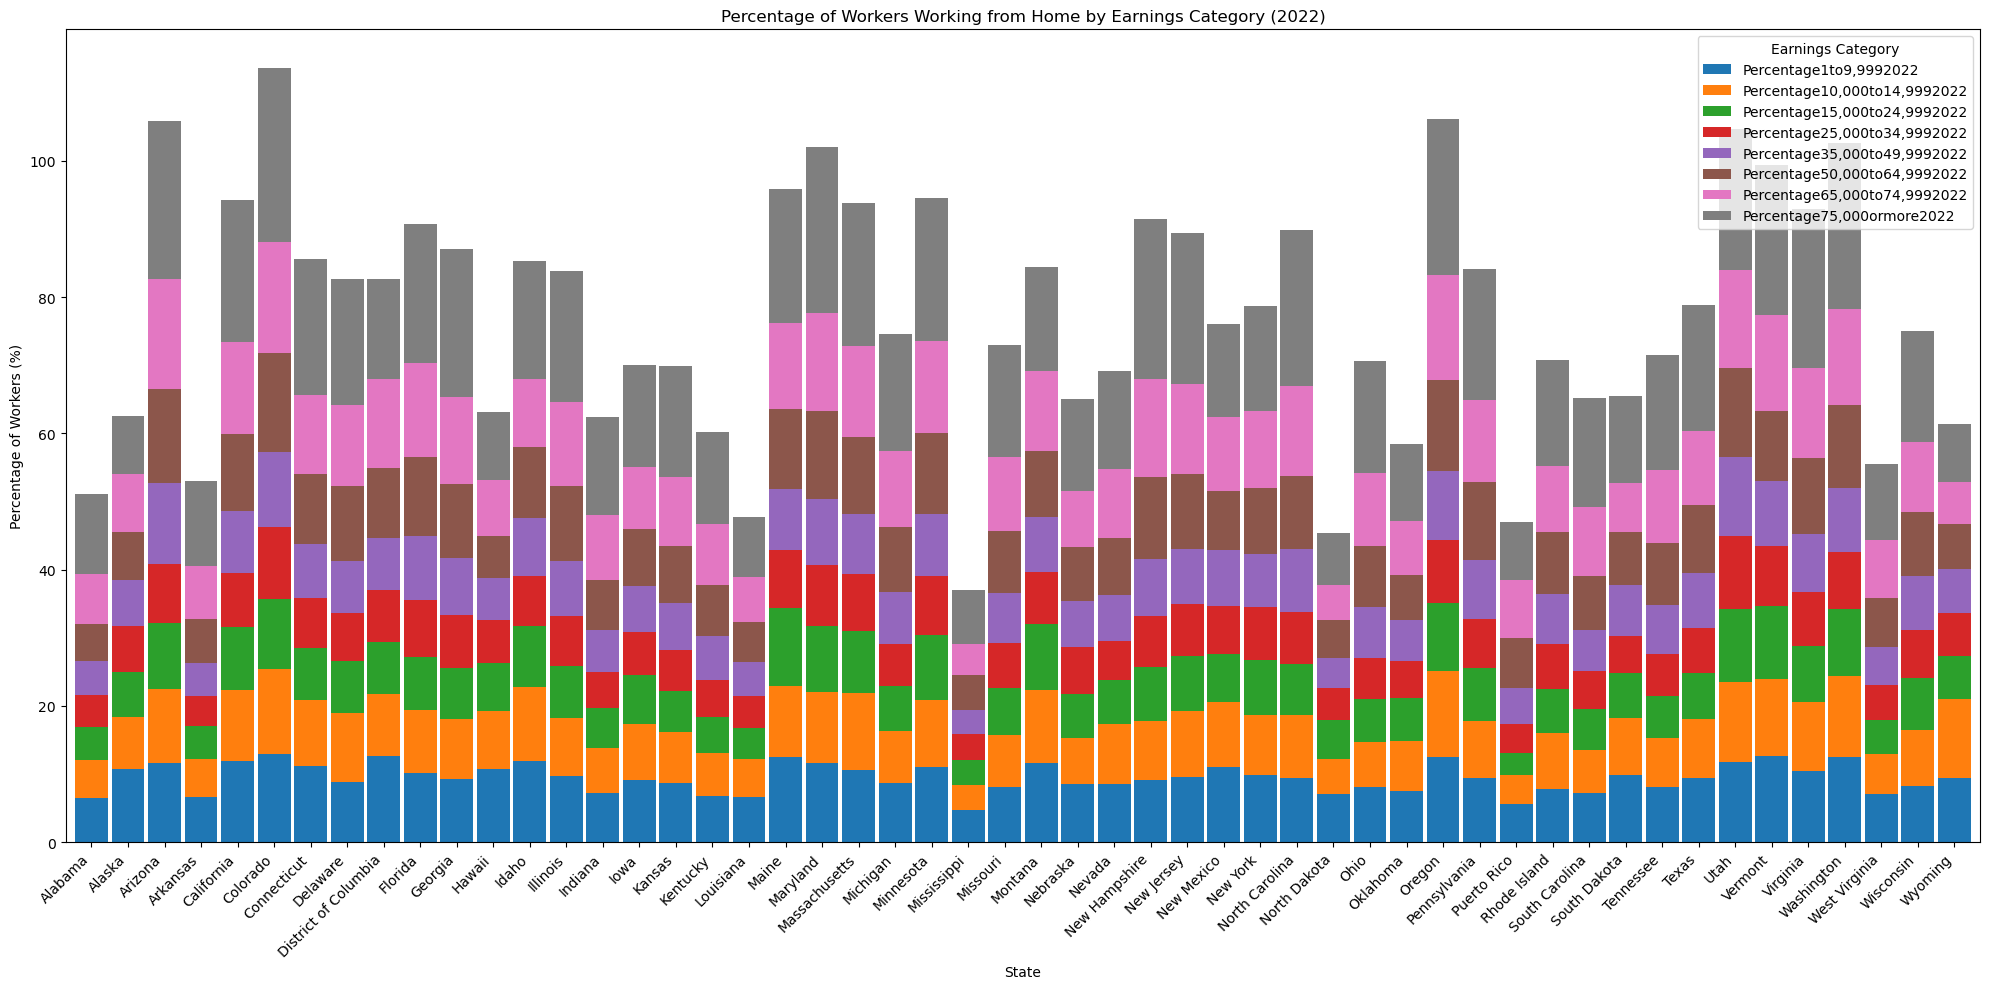

In [44]:
# Clean up column names by removing spaces (keeping commas and other symbols)
final_percentage_2022_df.columns = final_percentage_2022_df.columns.str.replace(' ', '')

# Define the categories (percentage columns)
categories_2022 = [
    'Percentage1to9,9992022',
    'Percentage10,000to14,9992022',
    'Percentage15,000to24,9992022',
    'Percentage25,000to34,9992022',
    'Percentage35,000to49,9992022',
    'Percentage50,000to64,9992022',
    'Percentage65,000to74,9992022',
    'Percentage75,000ormore2022'
]

# Clean the percentage values: remove '%' and ',' and convert to float
final_percentage_2022_df[categories_2022] = final_percentage_2022_df[categories_2022].replace({'%': '', ',': ''}).astype(float)

# Create a stacked bar chart
final_percentage_2022_df[categories_2022].plot(kind='bar', stacked=True, figsize=(20, 10), width=0.9)

# Adding title and labels
plt.title('Percentage of Workers Working from Home by Earnings Category (2022)')
plt.xlabel('State')
plt.ylabel('Percentage of Workers (%)')
plt.xticks(rotation=45, ha='right')  
plt.legend(title="Earnings Category", loc='upper right')  # Move legend outside the plot

# Display the plot
plt.tight_layout()
plt.show()

In [45]:
plt.savefig("./Images/earnings2022.png")

<Figure size 640x480 with 0 Axes>